In [1]:
#Functions for CSV Processing
from bdb import effective
import os
from pathlib import Path
from site import check_enableusersite
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
import math
from matplotlib.lines import Line2D
from collections import Counter

#Modify for IC5146 and other scales
scale_colors = {
    "16": "red",
    "32": "orange",
    "64": "lightblue",
    "128": "darkblue",
    "256": "purple"
}



def getInfo(label, csv_path):

    """
    Read the csv file for information about an image and return the distance, res, pixscale, and powers of 2

    Parameter
    - label (str): The label for the celestial object that the image is of, commonly a galaxy name
    - csv_path (str): The path to the csv file containing relevant information

    Returns:
    - distance (float): distance to the image
    - res (float): angular resolution
    - pixscale (float): pixel resolution
    - min_power (float): minimum power of 2 for scale decomposition
    - max_power (float): maximum power of 2 for scale decomposition

    """

    table = pd.read_excel(csv_path)
    label, band = label.split("_")

    try: 
        label_info = table[
            (table['label'].str.lower() == label.lower()) & 
            (table['Band'].str.lower() == band.lower())
        ]
    except KeyError as e:
        print("Error: Cannot find 'label' in csv file")
        exit(1)

    if not label_info.empty:
        distance = label_info.iloc[0]['current_dist']
        res = label_info.iloc[0]['res']
        pixscale = label_info.iloc[0]['pixscale']
        min_power = label_info.iloc[0]['Power of 2 min']
        max_power = label_info.iloc[0]['Power of 2 max']
        Rem_sources = label_info.iloc[0]['Rem_sources']
        Band = label_info.iloc[0]['Band']
        Instr = label_info.iloc[0]['INSTR']

        MJysr = np.nan #not needed

        return distance, res, pixscale, MJysr, Band, min_power, max_power, bool(Rem_sources)
    
    else: 
        print("Image not found in csv!")
        
def getScale(file):
    scales = ["256", "128", "64", "32", "16"]
    for scale in scales:
        if f"_{scale}" in file or f"{scale}pc" in file:
            return scale
    return None

def get_min_scale(synthetic_folder):
    min_scale = float('inf')
    for file in os.listdir(synthetic_folder):
        if file.endswith(".fits"):
            file_path = os.path.join(synthetic_folder, file)
            scale = getScale(file_path)
            if scale is not None and float(scale) < min_scale:
                min_scale = float(scale)
    return min_scale if min_scale != float('inf') else None

def plot_quantity(data_dict, quantity_type, ax, region = -1):
    region_dict = {
    1: "center",
    2: "bar",
    3: "bar",
    4: "interarm",
    5: "spiral",
    6: "spiral",
    7: "interarm",
    8: "interarm",
    9: "disc",
    10: "disc"
    }
    num_fils = 0
    for scale in sorted(data_dict.keys(), key=lambda x: float(x)):
        data = np.array(data_dict[scale])
        num_fils += len(data)
        # Skip if no data
        if len(data) == 0:
            print(f"Warning: No data for {quantity_type} at scale {scale}")
            continue
            
        if quantity_type == "curvature":
            plot_data = data
        else:
            plot_data = np.log10(data[data > 0])
            
        color = scale_colors.get(scale, None)
        if len(plot_data) > 0:  # Only plot if we have data
            sns.kdeplot(plot_data, label=f"{scale} pc", linewidth=2, color=color, ax=ax)

    # Set x-axis labels and limits
    ax.set_xlabel({
        "length": "log(pc)",
        "mass": "log(M☉)",
        "density": "log(M☉/pc)",
        "curvature": "Radians",
        "surface_density": "log(M☉/pc^2)"
    }[quantity_type])
    
    ax.set_ylabel("Density")
    if region != -1:
        region_label = region_dict.get(int(region))
        ax.set_title(f'{quantity_type.capitalize()} for region {region_label} ({int(region)}),\n {num_fils} total filaments')
    else:
        ax.set_title(quantity_type.capitalize())
    ax.grid(True, which="both", ls="--")

    # Set appropriate x-axis limits
    xlims = {
        "length": (1, 5),
        "mass": (2, 8),
        "density": (0, 8),
        "curvature": (0, 2),  
        "surface_density": (-3,5) 
        }
    if quantity_type in xlims:
        ax.set_xlim(xlims[quantity_type])




def plot_galaxy_image(fits_folder, galaxy_name, ax):
    try:
        for file in os.listdir(fits_folder):
            if file.endswith(".fits") and galaxy_name.lower() in file.lower():
                fits_path = os.path.join(fits_folder, file)
                with fits.open(fits_path) as hdul:
                    image_data = hdul[0].data
                    if image_data is not None:
                        image = np.nan_to_num(image_data)

                        # Pad image to square
                        y, x = image.shape
                        size = max(x, y)
                        pad_x = (size - x) // 2
                        pad_y = (size - y) // 2
                        image = np.pad(image, ((pad_y, size - y - pad_y), (pad_x, size - x - pad_x)), 
                                       mode='constant', constant_values=0)

                        vmin, vmax = (0,20) #Plot all galaxies with same scale
                        ax.imshow(image, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
                        ax.set_title(galaxy_name, fontsize=12)
                        ax.axis('off')
                        return
        ax.set_title(f"{galaxy_name} (Image Not Found)", fontsize=10)
        ax.axis('off')
    except Exception:
        ax.set_title(f"{galaxy_name} (Error)", fontsize=10)
        ax.axis('off')

def get_rows(galaxy_subset, galaxy_data):
    region_sum = 0
    for i, galaxy in enumerate(galaxy_subset):
        data = galaxy_data[galaxy]
        region_data = data['region']
        region_data_combined = []
        region_counts = []
        valid_regions = []
        for scale in sorted(region_data.keys(), key=lambda x: float(x)):
            region_data_combined.append(region_data[scale])
        region_data_combined = np.concatenate(region_data_combined)
        vals, freqs = np.unique(region_data_combined, return_counts=True)
        region_counts = dict(zip(vals, freqs))
        print(region_counts)
        valid_regions = [r for r, cnt in region_counts.items() if cnt >= 10]
        print(valid_regions)
        region_sum += len(valid_regions)
    return region_sum

def plot_galaxies_subset(galaxy_subset, filename, fits_folder, galaxy_data, output_folder, sort_region = False, Write = False):
    num = len(galaxy_subset)
    if sort_region:
        rows = get_rows(galaxy_subset, galaxy_data)
        fig = plt.figure(figsize=(25, 4.8 * num*rows))
        gs = gridspec.GridSpec(rows*num, 6, figure=fig)
        print(f'expected rows: {num*rows}')
    else:
        fig = plt.figure(figsize=(25, 4.8 * num))
        gs = gridspec.GridSpec(num, 6, figure=fig)

    start = 0
    for i, galaxy in enumerate(galaxy_subset):
        data = galaxy_data[galaxy]

        if sort_region:
            # master dicts: {region_val: {scale: values}}
            modified_mass_dict = {}
            modified_length_dict = {}
            modified_density_dict = {}
            modified_surface_density_dict = {}
            modified_curvature_dict = {}

            # per-scale dicts: {scale: values}
            sub_mass_dict = {}
            sub_length_dict = {}
            sub_density_dict = {}
            sub_surface_density_dict = {}
            sub_curvature_dict = {}

            data = galaxy_data[galaxy]
            region_data_all = data['region']  # dict of {scale: region_labels}

            for scale in sorted(region_data_all.keys(), key=lambda x: float(x)):
                region_for_scale = region_data_all[scale]
                vals, freqs = np.unique(region_for_scale, return_counts=True)
                region_counts = dict(zip(vals, freqs))
                valid_regions = [r for r, cnt in region_counts.items() if cnt >= 10]

                for region_val in valid_regions:
                    # extract raw values for this scale
                    mass = data["mass"][scale]
                    length = data["length"][scale]
                    density = data["density"][scale]
                    curvature = data["curvature"][scale]
                    surface_density = data["surface_density"][scale]

                    # filter by region
                    length_filtered = [b for a, b in zip(region_for_scale, length) if a == region_val]
                    mass_filtered = [b for a, b in zip(region_for_scale, mass) if a == region_val]
                    density_filtered = [b for a, b in zip(region_for_scale, density) if a == region_val]
                    curvature_filtered = [b for a, b in zip(region_for_scale, curvature) if a == region_val]
                    surface_density_filtered = [b for a, b in zip(region_for_scale, surface_density) if a == region_val]

                    # --- store in sub-dicts (per scale) ---
                    sub_length_dict[scale] = length_filtered
                    sub_mass_dict[scale] = mass_filtered
                    sub_density_dict[scale] = density_filtered
                    sub_curvature_dict[scale] = curvature_filtered
                    sub_surface_density_dict[scale] = surface_density_filtered

                    # --- store in master dicts (per region -> per scale) ---
                    modified_length_dict.setdefault(region_val, {})[scale] = length_filtered
                    modified_mass_dict.setdefault(region_val, {})[scale] = mass_filtered
                    modified_density_dict.setdefault(region_val, {})[scale] = density_filtered
                    modified_curvature_dict.setdefault(region_val, {})[scale] = curvature_filtered
                    modified_surface_density_dict.setdefault(region_val, {})[scale] = surface_density_filtered

            for j,region in enumerate(modified_length_dict.keys()):
                ax1 = fig.add_subplot(gs[j + start, 0])
                ax2 = fig.add_subplot(gs[j + start, 1])
                ax3 = fig.add_subplot(gs[j + start, 2])
                ax4 = fig.add_subplot(gs[j + start, 3])
                ax5 = fig.add_subplot(gs[j + start, 4])
                ax6 = fig.add_subplot(gs[j + start, 5])
                plot_quantity(modified_length_dict[region], "length", ax1, region)
                plot_quantity(modified_mass_dict[region], "mass", ax2, region)
                plot_quantity(modified_density_dict[region], "density", ax3, region)
                plot_quantity(modified_surface_density_dict[region], "surface_density", ax4, region)
                plot_quantity(modified_curvature_dict[region], "curvature", ax5, region)
                plot_galaxy_image(fits_folder, galaxy, ax6) 
            start = len(modified_length_dict.keys()) - 1 + i
        else:
            ax1 = fig.add_subplot(gs[i, 0])
            ax2 = fig.add_subplot(gs[i, 1])
            ax3 = fig.add_subplot(gs[i, 2])
            ax4 = fig.add_subplot(gs[i, 3])
            ax5 = fig.add_subplot(gs[i, 4])
            ax6 = fig.add_subplot(gs[i, 5])
            plot_quantity(data["length"], "length", ax1)
            plot_quantity(data["mass"], "mass", ax2)
            plot_quantity(data["density"], "density", ax3)
            plot_quantity(data["surface_density"], "surface_density", ax4)
            plot_quantity(data["curvature"], "curvature", ax5)
            plot_galaxy_image(fits_folder, galaxy, ax6)


        ax1.set_ylabel("Density")

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=color, lw=3)
        for scale, color in sorted(scale_colors.items(), key=lambda x: float(x[0]))
    ]
    fig.legend(handles=legend_elements,
               labels=[f"{scale} pc" for scale in sorted(scale_colors, key=float)],
               loc='upper center', bbox_to_anchor=(0.5, 1.1),
               ncol=len(scale_colors), fontsize=12, frameon=False)

    plt.subplots_adjust(top=0.98, hspace=0.35)

    output_path = output_folder / filename
    if Write: 
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
        fig.savefig(output_folder / (filename.replace('.png', '.pdf')), format='pdf', bbox_inches='tight')
    plt.show()

Error: for ngc1087_F770W 'Regions_32.0'
Error: for ngc1087_F770W 'Regions_64.0'
Error: for ngc1087_F770W 'Regions_128.0'
Error: for ngc1087_F770W 'Regions_256.0'
Error: for ngc1300_F770W 'Regions_32.0'
Error: for ngc1300_F770W 'Regions_64.0'
Error: for ngc1300_F770W 'Regions_128.0'
Error: for ngc1300_F770W 'Regions_256.0'
Error: for ngc1385_F770W 'Regions_32.0'
Error: for ngc1385_F770W 'Regions_64.0'
Error: for ngc1385_F770W 'Regions_128.0'
Error: for ngc1385_F770W 'Regions_256.0'
Error: for ngc1433_F770W 'Regions_16.0'
Error: for ngc1433_F770W 'Regions_32.0'
Error: for ngc1433_F770W 'Regions_64.0'
Error: for ngc1433_F770W 'Regions_128.0'
Error: for ngc1433_F770W 'Regions_256.0'
Error: for ngc1512_F770W 'Regions_32.0'
Error: for ngc1512_F770W 'Regions_64.0'
Error: for ngc1512_F770W 'Regions_128.0'
Error: for ngc1512_F770W 'Regions_256.0'
Error: for ngc1566_F770W 'Regions_32.0'
Error: for ngc1566_F770W 'Regions_64.0'
Error: for ngc1566_F770W 'Regions_128.0'
Error: for ngc1566_F770W 'Reg

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

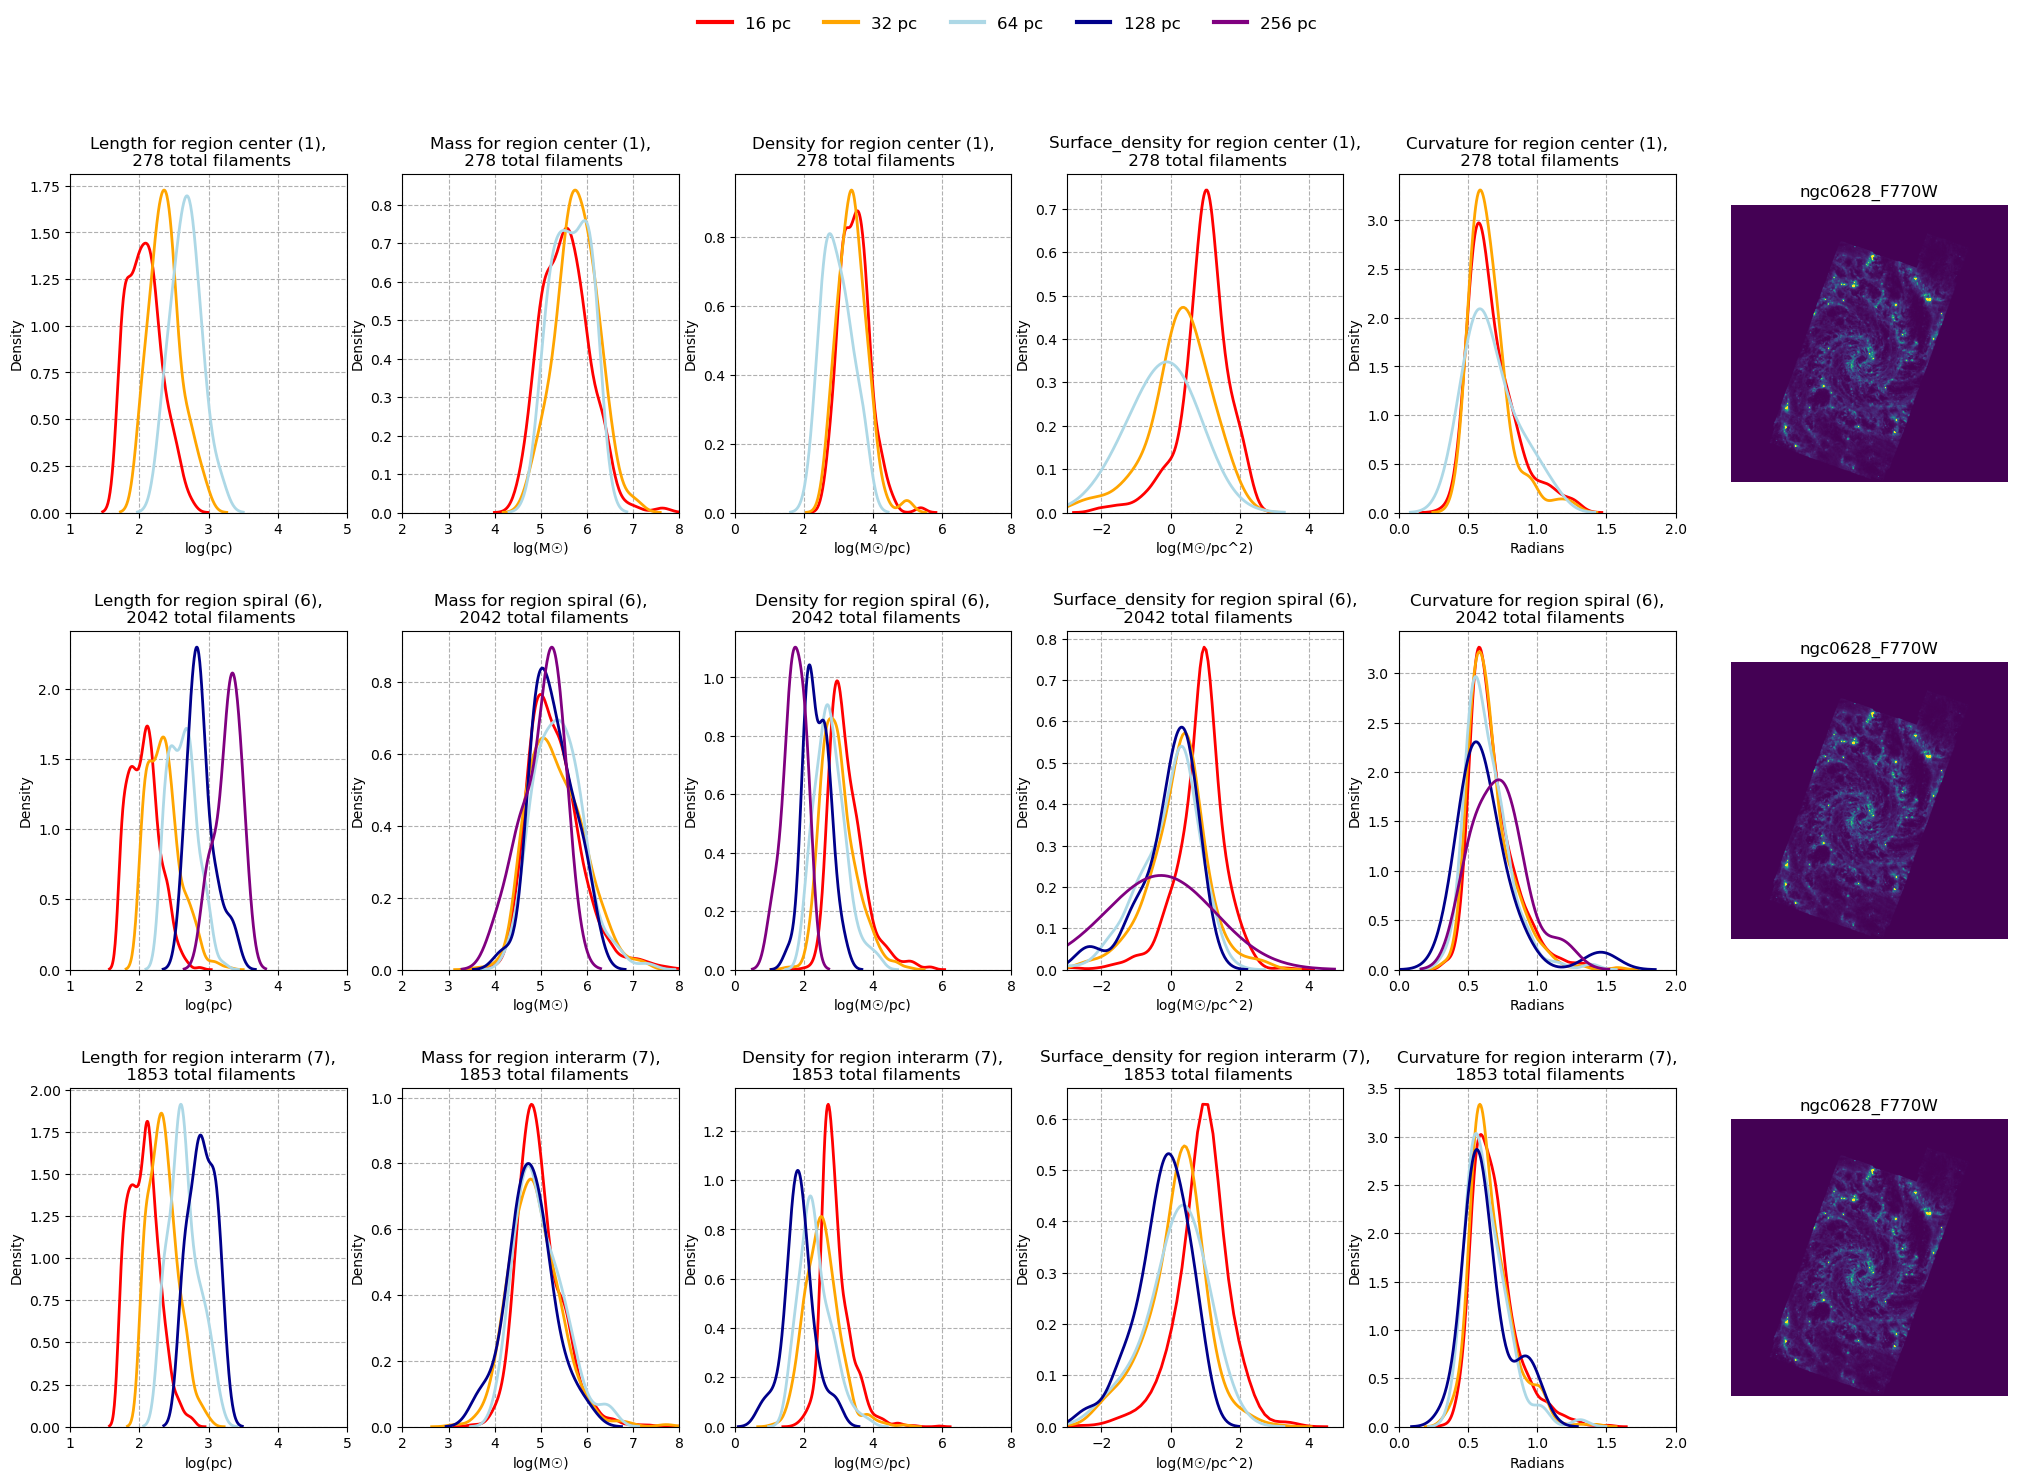

In [ ]:
# Base paths
base_dir = Path(r"C:\Users\jhoffm72\Documents\FilPHANGS\Data")
csv_path = Path(r"C:\Users\jhoffm72\Documents\FilPHANGS\Data\ImageData.xlsx")
fits_folder = base_dir / "OriginalImages"
output_folder = base_dir / "Figures"
output_folder.mkdir(exist_ok=True)
Num_Galaxies = 15
Galaxies_per_figure = 5

# Filter valid galaxy folders
galaxy_folders = [
    folder for folder in os.listdir(base_dir)
    if os.path.isdir(base_dir / folder)
    and folder not in ['Figures', 'OriginalImages', 'masks_v5_simple', 'IC5146_PSW']
    and not folder.endswith('.txt') and not folder.endswith('.xlsx')
]

valid_galaxies = []
galaxy_data = {}

for folder in galaxy_folders:
    galaxy_name = folder
    synthetic_folder = base_dir / folder / 'SyntheticMap'

    mass_dict = {}
    length_dict = {}
    density_dict = {}
    region_dict = {}
    curvature_dict = {}
    mass_surface = {}

    try:
        min_scale = get_min_scale(synthetic_folder)
        for file in os.listdir(synthetic_folder):
            if not file.endswith(".fits"):
                file_path = os.path.join(synthetic_folder, file)
                if file.endswith(".xlsx"):
                    df = pd.read_excel(file_path, engine='openpyxl')
                elif file.endswith(".xls"):
                    df = pd.read_excel(file_path)
                elif file.endswith(".csv"):
                    df = pd.read_csv(file_path)
                else:
                    continue

                scale = getScale(file_path)
                if scale is None:
                    continue

                try:
                    regions = df[f"Regions_{scale}.0"]
                    mass = df[f'Mass_{scale}.0']
                    Line_Density = df[f'Line_Density_{scale}.0'] #* (int(min_scale)/int(scale))
                    lengths = df[f'Length_{scale}.0'] #* (int(scale)/int(min_scale))
                    mass_dict[scale] = np.array(mass)
                    length_dict[scale] = np.array(lengths)
                    density_dict[scale] = np.array(Line_Density)
                    region_dict[scale] = np.array(regions)
                    curvature_col_name = f'Curvature_{scale}.0'

                    if curvature_col_name not in df.columns:
                        print(f"ERROR: Column '{curvature_col_name}' not found in dataframe!")
                        print(f"Available columns: {[col for col in df.columns if scale in col]}")
                        continue
                
                    curvature = df[curvature_col_name]
                    curvature_values = []

                    for i, s in enumerate(curvature):
                        if pd.isna(s):
                            continue
                        try:
                            if isinstance(s, (int, float, np.number)):
                                curvature_values.append(float(s))
                            elif isinstance(s, str):
                                numeric_part = s.split()[0]
                                curvature_values.append(float(numeric_part))
                            else:
                                print(f"Unexpected type at index {i}: {type(s)} - {s}")
                        except (ValueError, AttributeError) as e:
                            print(f"Error processing index {i}: {s} - {e}")
                            continue
                    

                    curvature_dict[scale] = np.array(curvature_values)

                except (KeyError, ValueError) as e:
                    print(f"Error: for {galaxy_name}", e)
                    continue

                try:
                    surface_density_path = base_dir / folder / 'Molecular_Mass'
                    distance_Mpc, _, pixscale, _, _, _, _, _ = getInfo(galaxy_name, csv_path)
                    ScalePix = pixscale * 4.848 * distance_Mpc
                    for fname in os.listdir(surface_density_path):
                        file = os.path.join(surface_density_path, fname)
                        if not file.lower().endswith(('.fits', '.fit', '.fz')) or not os.path.isfile(file):
                            continue
                        try:
                            scale = getScale(file)
                            with fits.open(file, ignore_missing=True) as hdul:
                                if hdul[0].data is None:
                                    print(f"No data in primary HDU for {file}")
                                    continue
                                OrigData = np.array(hdul[0].data)
                            surface_density_data = np.array(OrigData.flatten()) / (ScalePix**2)  
                            surface_density_data = np.array(surface_density_data[surface_density_data != 0])
                            Npix = 1.13 * (16 / ScalePix) ** 2 * int(scale) / 16
                            mass_surface[scale] = np.array(surface_density_data) / Npix

                        except Exception as e:
                            print(f"Error: for {galaxy_name}", e)
                            continue

                except Exception as e:
                    print(f"Error: for {galaxy_name}", e)
                    continue

        if length_dict:
            valid_galaxies.append(galaxy_name)
            galaxy_data[galaxy_name] = {
                "mass": mass_dict,
                "length": length_dict,
                "density": density_dict,
                'region': region_dict,
                'curvature': curvature_dict,
                'surface_density': mass_surface
            }
    except Exception as e:
        print("Error:", e)

plot_galaxies_subset(valid_galaxies[:Galaxies_per_figure], "First6Galaxies_Summary.png", fits_folder, galaxy_data, output_folder,sort_region = True)
# plot_galaxies_subset(valid_galaxies[Galaxies_per_figure:2*Galaxies_per_figure], "Middle6Galaxies_Summary.png",fits_folder, galaxy_data, output_folder, sort_region = True)
# plot_galaxies_subset(valid_galaxies[-Galaxies_per_figure:], "Last6Galaxies_Summary.png",fits_folder, galaxy_data, output_folder, sort_region = True)

In [3]:
# Combine data across all galaxies. TO FIX!
for galaxy in valid_galaxies:
    mass_data = galaxy_data[galaxy]["mass"]
    length_data = galaxy_data[galaxy]["length"]
    density_data = galaxy_data[galaxy]["density"]
    aspect_data = galaxy_data[galaxy]["aspect"]
    curvature_data = galaxy_data[galaxy]["curvature"]
    surface_density_data = galaxy_data[galaxy]["surface_density"]
    for scale in scales:
        try:
            master_dict["mass"][scale].append(mass_data[scale])
            master_dict["length"][scale].append(length_data[scale])
            master_dict["density"][scale].append(density_data[scale])
            master_dict["aspect"][scale].append(aspect_data[scale])
            master_dict["curvature"][scale].append(curvature_data[scale])
            master_dict["surface_density"][scale].append(surface_density_data[scale])

        except KeyError:
            # Skip if this galaxy doesn't have data for this scale
            continue

# Convert lists of arrays into flat numpy arrays
for quantity in master_dict:
    for scale in master_dict[quantity]:
        if master_dict[quantity][scale]:  # Avoid empty lists
            master_dict[quantity][scale] = np.concatenate(master_dict[quantity][scale])
        else:
            master_dict[quantity][scale] = np.array([])  # fallback for missing data
fig, axes = plt.subplots(1, 5, figsize=(24, 6))

plot_quantity(master_dict["length"], "length", axes[0])
plot_quantity(master_dict["mass"], "mass", axes[1])
plot_quantity(master_dict["density"], "density", axes[2])
plot_quantity(master_dict["surface_density"], "surface_density", axes[3])
plot_aspect_ratio(master_dict["aspect"], axes[4])
plot_quantity(master_dict["curvature"], "curvature", axes[5])  # <-- was axes[3]


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=color, lw=3)
    for scale, color in sorted(scale_colors.items(), key=lambda x: float(x[0]))
]
fig.legend(
    handles=legend_elements,
    labels=[f"{scale} pc" for scale in sorted(scale_colors, key=float)],
    loc='upper center', bbox_to_anchor=(0.5, 1.05),
    ncol=len(scale_colors), fontsize=12, frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Combined Distribution Across All Galaxies", fontsize=16)

# Save the plot
final_combined_path = output_folder / "AllGalaxies_Combined_Corrected.png"
fig.savefig(final_combined_path, dpi=300, bbox_inches='tight')
fig.savefig(final_combined_path.with_suffix(".pdf"), format='pdf', bbox_inches='tight')
plt.show()

KeyError: 'aspect'